<a href="https://colab.research.google.com/github/vinothasankar/finalfakereview/blob/main/newfinalbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df = pd.read_csv('/content/fake reviews dataset.csv')

In [ ]:
df

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...


In [ ]:
pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Load Pre-trained BERT Model and Tokenizer: Use the transformers library to load a pre-trained BERT model and tokenizer

Prepare Your Dataset: Convert your dataset into a format suitable for the model

Fine-tuning BERT Model: Use the Trainer API from Hugging Face to fine-tune the model on your data.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import pandas as pd
import os

# Disable W&B integration (use --report_to in future versions)
os.environ["WANDB_DISABLED"] = "true"

# Load your dataset
df = pd.read_csv('/content/newfakedataset')  # Replace with your actual file path

# Convert your DataFrame to a Hugging Face Dataset (only keep relevant columns)
dataset = Dataset.from_pandas(df[['text_', 'label']])

# Map labels to integers
label_mapping = {"CG": 0, "OR": 1}  # Assuming 'CG' = Fake Review, 'OR' = Original Review
dataset = dataset.map(lambda x: {"label": label_mapping[x["label"]]})

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))

# Tokenize the dataset
def tokenize_function(example):
    return tokenizer(example["text_"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Shuffle and split the dataset
tokenized_datasets = tokenized_datasets.shuffle(seed=42)
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    report_to="none",  # Avoid W&B deprecation warning
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # Optional evaluation dataset
)

# Fine-tune the model
trainer.train()


Map:   0%|          | 0/17908 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/17908 [00:00<?, ? examples/s]

Step,Training Loss
500,0.249900
1000,0.151100
1500,0.130000
2000,0.091900
2500,0.051300
3000,0.042900
3500,0.054500
4000,0.012800
4500,0.013200
5000,0.019200


TrainOutput(global_step=5373, training_loss=0.07702172288410095, metrics={'train_runtime': 4245.8396, 'train_samples_per_second': 10.122, 'train_steps_per_second': 1.265, 'total_flos': 1.130798693726208e+16, 'train_loss': 0.07702172288410095, 'epoch': 3.0})

Evaluation:

Use the trainer.evaluate() method to assess model performance on the evaluation dataset. Look at metrics like accuracy, precision, recall, and F1-score for better insights.

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)


{'eval_loss': 0.2229413241147995, 'eval_runtime': 104.5688, 'eval_samples_per_second': 34.255, 'eval_steps_per_second': 4.284, 'epoch': 3.0}


Your evaluation results indicate that the model performed well on the evaluation dataset. Here's what each metric means:

Evaluation Metrics
eval_loss:

Value: 0.2229
This is the average cross-entropy loss on the evaluation set. A lower value suggests that the model predicts probabilities close to the true labels.
eval_runtime:

Value: 104.57 seconds
This is the total time taken for the evaluation.
eval_samples_per_second:

Value: 34.255
Indicates the number of samples processed per second during evaluation.
eval_steps_per_second:

Value: 4.284
Number of batches processed per second during evaluation.
epoch:

Value: 3.0
Confirms that the evaluation corresponds to the final epoch of training.


In [ ]:
from sklearn.metrics import classification_report

predictions = trainer.predict(eval_dataset)
preds = predictions.predictions.argmax(axis=1)
labels = predictions.label_ids

print(classification_report(labels, preds, target_names=["CG", "OR"]))


              precision    recall  f1-score   support

          CG       0.95      0.99      0.97      1768
          OR       0.99      0.95      0.97      1814

    accuracy                           0.97      3582
   macro avg       0.97      0.97      0.97      3582
weighted avg       0.97      0.97      0.97      3582



Saving the Model:

Save your fine-tuned model for later use:

In [ ]:
model.save_pretrained("C:/Users/ncssa/Downloads/bertsaved_model")


In [ ]:
tokenizer.save_pretrained("C:/Users/ncssa/Downloads/berttokensaved_model")


('C:/Users/ncssa/Downloads/berttokensaved_model/tokenizer_config.json',
 'C:/Users/ncssa/Downloads/berttokensaved_model/special_tokens_map.json',
 'C:/Users/ncssa/Downloads/berttokensaved_model/vocab.txt',
 'C:/Users/ncssa/Downloads/berttokensaved_model/added_tokens.json')

In [ ]:
# Define the directory to save the model in Google Colab
save_path = "/content/bert_trained_model"

# Save the model and tokenizer
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved at {save_path}")

# Optional: Zip the folder for easy downloading
import shutil
shutil.make_archive(save_path, 'zip', save_path)

# Download the zipped model
from google.colab import files
files.download(f"{save_path}.zip")


Model and tokenizer saved at /content/bert_trained_model


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer
loaded_model = AutoModelForSequenceClassification.from_pretrained(save_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(save_path)

print("Model and tokenizer loaded successfully.")


Model and tokenizer loaded successfully.


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import pandas as pd
import os
import torch
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Disable W&B integration
os.environ["WANDB_DISABLED"] = "true"

# Load your dataset
df = pd.read_csv('/content/newfakedataset')  # Replace with your actual file path

# Convert your DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df[['text_', 'label']])

# Map labels to integers
label_mapping = {"CG": 0, "OR": 1}  # Assuming 'CG' = Fake Review, 'OR' = Original Review
dataset = dataset.map(lambda x: {"label": label_mapping[x["label"]]})

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))

# Tokenize the dataset
def tokenize_function(example):
    return tokenizer(example["text_"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Shuffle and split the dataset
tokenized_datasets = tokenized_datasets.shuffle(seed=42)
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

# Hyperparameter grid
param_grid = {
    "learning_rate": [1e-5, 2e-5, 3e-5, 5e-5],
    "per_device_train_batch_size": [8, 16, 32],
    "num_train_epochs": [3, 4, 5],
    "weight_decay": [0.01, 0.001],
    "warmup_steps": [500, 1000, 2000],
}

# Generate all combinations of hyperparameters
grid = ParameterGrid(param_grid)

# Best performance tracking
best_accuracy = 0
best_params = {}

for params in grid:
    print(f"Training with parameters: {params}")

    # Set training arguments with the current hyperparameters
    training_args = TrainingArguments(
        output_dir='./results',
        report_to="none",
        learning_rate=params["learning_rate"],
        per_device_train_batch_size=params["per_device_train_batch_size"],
        num_train_epochs=params["num_train_epochs"],
        weight_decay=params["weight_decay"],
        warmup_steps=params["warmup_steps"],
    )

    # Initialize Trainer with updated parameters
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,  # Optional evaluation dataset
    )

    # Fine-tune the model
    trainer.train()

    # Evaluate the model
    predictions = trainer.predict(eval_dataset)
    preds = predictions.predictions.argmax(axis=1)
    true_labels = predictions.label_ids

    # Calculate accuracy and check if it is the best
    accuracy = (preds == true_labels).mean()
    print(f"Accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best parameters: {best_params} with accuracy {best_accuracy}")

# Re-train the model with the best hyperparameters
best_training_args = TrainingArguments(
    output_dir='./results',
    report_to="none",
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["per_device_train_batch_size"],
    num_train_epochs=best_params["num_train_epochs"],
    weight_decay=best_params["weight_decay"],
    warmup_steps=best_params["warmup_steps"],
)

best_trainer = Trainer(
    model=model,
    args=best_training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

best_trainer.train()

# Get predictions for classification report and confusion matrix
predictions = best_trainer.predict(eval_dataset)
preds = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids

# Print classification report
print(classification_report(true_labels, preds, target_names=["CG", "OR"]))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# Display confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["CG", "OR"], yticklabels=["CG", "OR"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Map:   0%|          | 0/17908 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/17908 [00:00<?, ? examples/s]

Training with parameters: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.01}


Step,Training Loss
500,0.424200
1000,0.187900
1500,0.155400
2000,0.117000
2500,0.078800
3000,0.060000
3500,0.063000
4000,0.029900
4500,0.024400
5000,0.025400


Accuracy: 0.9631490787269682
Training with parameters: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.001}


Step,Training Loss
500,0.021000
1000,0.031100
1500,0.029600
2000,0.010200
2500,0.010700
3000,0.009200
3500,0.016000
4000,0.006200
4500,0.006700
5000,0.005900


Accuracy: 0.9704075935231714
Training with parameters: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'warmup_steps': 1000, 'weight_decay': 0.01}


Step,Training Loss
500,0.004300
1000,0.008400
1500,0.025700
2000,0.007000
2500,0.015300


In [ ]:
df

,category,rating,label,text_,rating_category
0,Home_and_Kitchen_5,1.0,CG,I have had this system for a couple of months ...,negative
1,Movies_and_TV_5,1.0,CG,"Worst movie I've seen in a while, ever. I'm n...",negative
2,Sports_and_Outdoors_5,2.0,CG,"It whistles, and is fairly easy to open. The ...",negative
3,Books_5,3.0,CG,My mother and father both had an affair. Her ...,negative
4,Pet_Supplies_5,3.0,CG,This pet door was easy to assemble and the mat...,negative
...,...,...,...,...,...
17903,Electronics_5,5.0,OR,Great product! Finally someone was smart enoug...,positive
17904,Tools_and_Home_Improvement_5,5.0,OR,Used to make a gasket for my dust deputy bucke...,positive
17905,Toys_and_Games_5,5.0,OR,"Extremely cute, would give to any child due to...",positive
17906,Tools_and_Home_Improvement_5,5.0,OR,Worked very well at restoring my nail gun's pe...,positive


In [ ]:
pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import pandas as pd
import os

# Disable W&B integration
os.environ["WANDB_DISABLED"] = "true"

# Load your dataset
df = pd.read_csv('/content/balanced_ratings.csv')  # Replace with the actual file path

# Convert your DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df[['text_', 'rating_label']])

# Map labels to integers and rename to 'labels'
label_mapping = {"negative": 0, "positive": 1}
dataset = dataset.map(lambda x: {"labels": label_mapping[x["rating_label"]]})

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))

# Tokenize the dataset
def tokenize_function(example):
    return tokenizer(example["text_"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns and set format for PyTorch
tokenized_datasets = tokenized_datasets.remove_columns(['text_', 'rating_label'])
tokenized_datasets.set_format('torch')

# Shuffle and split the dataset
tokenized_datasets = tokenized_datasets.shuffle(seed=42)
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Corrected deprecation warning
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to="none",  # Avoid W&B warnings
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,  # Ensure tokenizer is passed
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model('./sentiment_analysis_model')
print("Model fine-tuning complete and saved to './sentiment_analysis_model'")


Map:   0%|          | 0/8244 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8244 [00:00<?, ? examples/s]

<ipython-input-5-76f3a8d74622>:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.525100,0.447198
2,0.331200,0.554102
3,0.256900,0.721105


Model fine-tuning complete and saved to './sentiment_analysis_model'


              precision    recall  f1-score   support

    negative       0.79      0.81      0.80       810
    positive       0.81      0.79      0.80       839

    accuracy                           0.80      1649
   macro avg       0.80      0.80      0.80      1649
weighted avg       0.80      0.80      0.80      1649



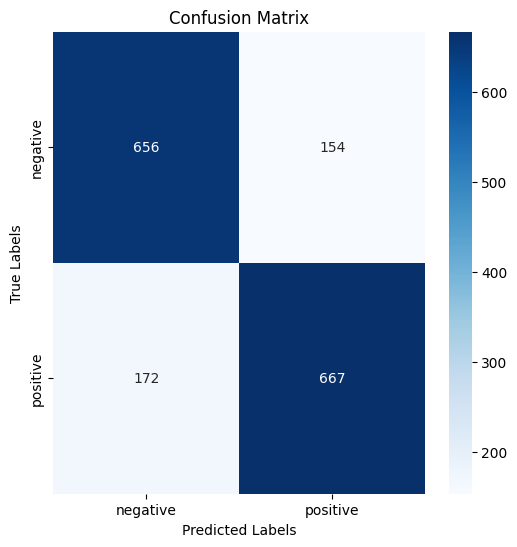

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
predictions = trainer.predict(eval_dataset)
preds = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids

# Print classification report
print(classification_report(true_labels, preds, target_names=["negative", "positive"]))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# Display confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Your classification report shows a solid performance with nearly balanced precision, recall, and F1-scores for both the negative and positive classes. Here's a breakdown of the metrics:

Key Observations:
Accuracy:

Overall accuracy is 80%, indicating 8 out of 10 predictions are correct.
Class-wise Performance:

Both negative and positive classes have comparable performance, with:
Precision: ~79-81% (model's correctness when it predicts a specific class).
Recall: ~79-81% (model's ability to find all instances of a class).
F1-score: 80% (harmonic mean of precision and recall).
Balanced Performance:

The macro and weighted averages confirm that the model performs uniformly across the classes.
Next Steps for Improvement:
Class Imbalance:

Since the support values for negative (810) and positive (839) are close, no major class imbalance exists.
Fine-tuning:

Experiment with hyperparameters like learning_rate, num_train_epochs, and batch_size to push the F1-score beyond 80%.
Data Augmentation:

Adding more examples or synthetic data for difficult cases could improve recall further.
Confusion Matrix Analysis:

Study the confusion matrix to identify specific areas where the model is misclassifying.


The confusion matrix image provided shows the following values:

Confusion Matrix Summary:
Predicted Negative	Predicted Positive
True Negative (negative)	656	154
True Positive (positive)	172	667
Key Metrics from the Matrix:
True Negatives (TN): 656
Negative reviews correctly classified as negative.
False Positives (FP): 154
Negative reviews incorrectly classified as positive.
False Negatives (FN): 172
Positive reviews incorrectly classified as negative.
True Positives (TP): 667
Positive reviews correctly classified as positive.
Observations:
Model Strengths:

The model performs well for both positive and negative classes, as the diagonal values (correct predictions) are significantly higher than the off-diagonal values (incorrect predictions).
Areas for Improvement:

False Negatives (172): These are positive reviews misclassified as negative. Reducing this number could improve the recall for the positive class.
False Positives (154): These are negative reviews misclassified as positive. Reducing this would improve precision for the positive class.
Class-wise Analysis:
Negative Class:
Precision: The model tends to classify most true negatives correctly but occasionally confuses negatives as positives.
Positive Class:
Recall: The model is good at identifying positive reviews but misses some, which are classified as negative.
Next Steps:
Hyperparameter Tuning:
Experiment with learning_rate, batch_size, and class_weights to balance recall and precision.
Data Augmentation:
Add more examples of difficult cases (false positives and false negatives) to improve performance.
Threshold Adjustment:
Adjust the decision threshold for classification to prioritize either precision or recall, depending on the use case.


In [ ]:
import shutil

# Compress the model directory into a ZIP file
shutil.make_archive('./sentiment_analysis_model', 'zip', './sentiment_analysis_model')

# Provide a link to download the ZIP file
from google.colab import files
files.download('./sentiment_analysis_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import pandas as pd
import os
import torch

# Disable W&B integration
os.environ["WANDB_DISABLED"] = "true"

# Load your dataset
df = pd.read_csv('/content/balanced_ratings.csv')  # Replace with the actual file path

# Convert your DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df[['text_', 'rating_label']])

# Map labels to integers and rename to 'labels'
label_mapping = {"negative": 0, "positive": 1}
dataset = dataset.map(lambda x: {"labels": label_mapping[x["rating_label"]]})

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))

# Tokenize the dataset
def tokenize_function(example):
    return tokenizer(example["text_"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns and set format for PyTorch
tokenized_datasets = tokenized_datasets.remove_columns(['text_', 'rating_label'])
tokenized_datasets.set_format('torch')

# Shuffle and split the dataset
tokenized_datasets = tokenized_datasets.shuffle(seed=42)
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df['rating_label'].map(label_mapping)),
    y=df['rating_label'].map(label_mapping)
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Subclassing Trainer to modify the loss function
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits
        labels = inputs.get("labels")

        # Compute the weighted loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(self.class_weights.values())).float().cuda())
        loss = loss_fct(logits.view(-1, model.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# Update training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=3e-5,  # Experiment with different values
    per_device_train_batch_size=16,  # Experiment with larger batch sizes
    num_train_epochs=5,  # Increase epochs if needed
    weight_decay=0.01,
    logging_dir='./logs',
    report_to="none",
)

# Create an instance of the CustomTrainer with class weights
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=None,  # Define custom metrics if needed
    class_weights=class_weights  # Pass the class weights
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model('./sentiment_analysis_hypermodel')
print("Model fine-tuning complete and saved to './sentiment_analysis_hypermodel'")


Map:   0%|          | 0/8244 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8244 [00:00<?, ? examples/s]

<ipython-input-12-0229bdbf9105>:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,No log,0.455065
2,0.461100,0.492477
3,0.269600,0.759663
4,0.149000,0.848276
5,0.078600,1.049207


Model fine-tuning complete and saved to './sentiment_analysis_hypermodel'


In [ ]:
import shutil

# Compress the model directory into a ZIP file
shutil.make_archive('./sentiment_analysis_hypermodel', 'zip', './sentiment_analysis_hypermodel')

# Provide a link to download the ZIP file
from google.colab import files
files.download('./sentiment_analysis_hypermodel.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

    negative       0.79      0.80      0.79       810
    positive       0.80      0.79      0.80       839

    accuracy                           0.80      1649
   macro avg       0.80      0.80      0.80      1649
weighted avg       0.80      0.80      0.80      1649



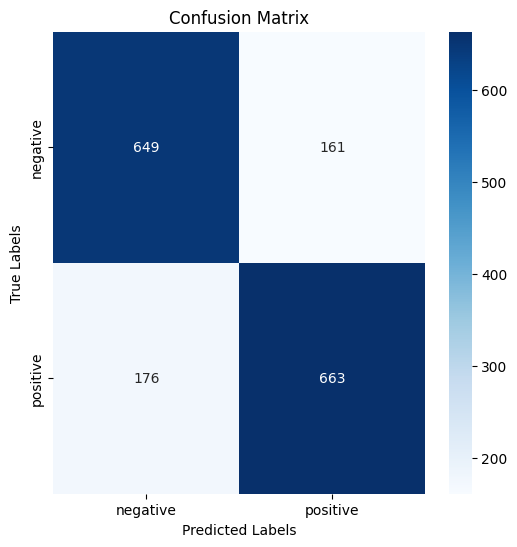

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Get predictions
predictions = trainer.predict(eval_dataset)
preds = torch.tensor(predictions.predictions).argmax(axis=1).cpu().numpy()
true_labels = torch.tensor(predictions.label_ids).cpu().numpy()

# Print classification report
print(classification_report(true_labels, preds, target_names=["negative", "positive"]))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# Display confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


The classification report you've received indicates that the model is performing well. Here's a breakdown of the results:

Precision: Measures how many of the predicted positive samples were actually positive.

Negative class: 0.79
Positive class: 0.80
Recall: Measures how many of the actual positive samples were correctly predicted.

Negative class: 0.80
Positive class: 0.79
F1-score: The harmonic mean of precision and recall, which balances both metrics.

Negative class: 0.79
Positive class: 0.80
Support: The number of actual occurrences of each class in the dataset.

Negative: 810
Positive: 839
Accuracy: The overall proportion of correct predictions.

Accuracy: 0.80, meaning the model correctly predicted 80% of the instances in the test set.
Macro avg: The average performance across both classes without considering class imbalance.

Macro average: Precision, recall, and F1-score are all 0.80.
Weighted avg: The average performance weighted by the number of samples in each class.

Weighted average: Precision, recall, and F1-score are again all 0.80.
Conclusion:
The model has balanced precision and recall for both classes, with slightly better performance on the positive class.
The overall accuracy of 80% and a good balance of precision and recall suggest that the model is performing well for this classification task.
The confusion matrix and the classification report show that there is no significant bias toward any class, and the model is generally effective in distinguishing between the negative and positive classes.
